# Results

In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [2]:
import os
from functools import partial
# import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline

from helpers import smooth_model_outputs, subsample_train, score_priority

# from matplotlib import gridspec
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier

from automated_scoring.classification import (
    plot_classification_timeline,
    plot_confusion_matrix,
    predict,
)
from automated_scoring.config import cfg
from automated_scoring.features import DataFrameFeatureExtractor
from automated_scoring.io import from_yaml, load_dataset, to_cache, from_cache
from automated_scoring.utils import Experiment
from automated_scoring.sliding_metrics import (
    SlidingWindowAggregator,
    get_window_slices,
    metrics,
)

# from observation_library.utils import adjust_lightness

In [3]:
cfg.key_keypoints = "pose"
cfg.key_timestamp = "time_stamp"

cfg.trajectory_keys = ("pose", "time_stamp")

## Example train and test run

In [4]:
# load training and test datasets
dataset_full = load_dataset(
    "cichlids",
    directory="../../datasets/social_cichlids",
    target="dyad",
    background_category="none",
)

dataset_train, dataset_test = dataset_full.split(
    0.8,
    random_state=1,
)

time_scales, slices = get_window_slices(3, time_scales=(91,))

aggregator = ColumnTransformer(
    [
        (
            "aggregate",
            SlidingWindowAggregator(
                [metrics.median, metrics.q10, metrics.q90], max(time_scales), slices
            ),
            make_column_selector(),
        ),
        ("original", "passthrough", make_column_selector()),
    ],
)

pipeline = Pipeline(
    [("impute", KNNImputer()), ("aggregate", aggregator)]
).set_output(transform="pandas")

extractor = DataFrameFeatureExtractor(
    cache_directory="/media/paul/Data1/cichlids_cache",
    pipeline=pipeline,
    refit_pipeline=True,
).read_yaml("config_file-cichlids.yaml")

# # set a fixed random state for reproducible results
# random_state = np.random.default_rng(1)

# # subsample dataset and encode target from string to numeric
# X, y = subsample_train(
#     dataset_train,
#     extractor,
#     random_state=random_state,
#     log=None,
# )
# y = dataset_train.encode(y)

# # specify and fit classification model
# classifier = XGBClassifier(n_estimators=1000, random_state=random_state).fit(
#     X.to_numpy(), y, sample_weight=compute_sample_weight("balanced", y)
# )

# # use model for predictions on the test dataset
# test_result = predict(
#     dataset_test,
#     classifier,
#     extractor,
#     log=None,
# )

best_parameters = from_yaml("optimization-summary.yaml")

priority_function = partial(
    score_priority,
    weight_max_probability=best_parameters["weight_max_probability"],
    weight_mean_probability=1 - best_parameters["weight_max_probability"],  # this is obviously wrong :facepalm:
)
best_thresholds = [best_parameters[f"threshold-{category}"] for category in dataset_test.categories]

# (
#     test_result
#     .smooth(partial(smooth_model_outputs, best_parameters), decision_thresholds=best_thresholds)
#     .remove_overlapping_predictions(
#         priority_function=priority_function,
#         prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
#         max_bout_gap=best_parameters["max_bout_gap"],
#         max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
#     )
#     .score()
# )

2025-04-29 19:54:34.296 [WARNING ] Loading categories (approach, chase, dart_bite, frontal_display, lateral_display, none, quiver) from observations file, specify categories argument if incomplete.
2025-04-29 19:54:48.470 [WARNING ] Time scales adjusted to match num_windows_per_scale: (91,) -> [93].


In [6]:
observations = dataset_full.observations

In [11]:
observations.groupby("category").aggregate({"duration": "sum"})

,duration
category,
approach,7699
chase,7412
dart_bite,12318
frontal_display,39569
lateral_display,14179
none,24910846
quiver,10053


In [5]:
def summarize_scores(result, *, foreground_categories, run, postprocessing_step):
    scores = test_result.score()
    summary = scores.stack().reset_index()
    summary = pd.DataFrame(
        np.array(summary[0]),
        index=summary["level_0"] + "_f1" + "-" + summary["level_1"],
    ).T
    columns = summary.columns
    summary["run"] = run
    summary["postprocessing_step"] = postprocessing_step
    summary = summary[["run", "postprocessing_step", *columns]]
    for level in scores.index:
        summary[f"{level}_f1-macro-foreground"] = scores.loc[level, list(foreground_categories)].mean()
        summary[f"{level}_f1-macro-all"] = scores.loc[level].mean()
    summary.columns = pd.MultiIndex.from_tuples(
        [(column.split("-", 1) if "-" in column else (column, "")) for column in summary.columns]
    )
    return summary

In [6]:
from tqdm.auto import tqdm

In [ ]:
# cache_directory = "/media/paul/Data1/samples_cache"
# experiment = Experiment(20, random_state=1)

# for run in tqdm(experiment, total=experiment.num_runs):
    
#     # X, y = subsample_train(
#     #     dataset_train,
#     #     extractor,
#     #     random_state=experiment.random_state,
#     #     log=None,
#     # )
#     # y = dataset_train.encode(y)

#     # classifier = XGBClassifier(n_estimators=1000, random_state=experiment.random_state).fit(
#     #     X.to_numpy(), y, sample_weight=compute_sample_weight("balanced", y)
#     # )

#     classifier = from_cache(os.path.join(cache_directory, f"clf_{run:02d}.cache"))

#     summary = []
#     y = {"true": {}, "pred": {}}

#     test_result = (
#         predict(dataset_test, classifier, extractor, log=None)
#         .remove_overlapping_predictions(
#             priority_function=priority_function,
#             prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
#             max_bout_gap=best_parameters["max_bout_gap"],
#             max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
#         )
#     )
#     summary.append(
#         summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="model_outputs",
#         )
#     )

#     test_result = (
#         test_result.smooth(partial(smooth_model_outputs, best_parameters))
#         .remove_overlapping_predictions(
#             priority_function=priority_function,
#             prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
#             max_bout_gap=best_parameters["max_bout_gap"],
#             max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
#         )
#     )
#     summary.append(
#         summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="smoothed",
#         )
#     )

#     test_result = (
#         test_result.threshold(best_thresholds, default_decision="none")
#         .remove_overlapping_predictions(
#             priority_function=priority_function,
#             prefilter_recipient_bouts=best_parameters["prefilter_recipient_bouts"],
#             max_bout_gap=best_parameters["max_bout_gap"],
#             max_allowed_bout_overlap=best_parameters["max_allowed_bout_overlap"],
#         )
#     )
#     summary.append(
#         summarize_scores(
#             test_result,
#             foreground_categories=dataset_test.foreground_categories,
#             run=run,
#             postprocessing_step="thresholded",
#         )
#     )

#     summary = pd.concat(summary, ignore_index=True)

#     y["true"]["timestamp"] = test_result.y_true_numeric
#     y["pred"]["timestamp"] = test_result.y_pred_numeric
#     y["true"]["annotation"] = dataset_test.encode(test_result.annotations["category"].to_numpy())
#     y["pred"]["annotation"] = dataset_test.encode(test_result.annotations["predicted_category"].to_numpy())
#     y["true"]["prediction"] = dataset_test.encode(test_result.predictions["true_category"].to_numpy())
#     y["pred"]["prediction"] = dataset_test.encode(test_result.predictions["category"].to_numpy())

#     experiment.add((summary, y))

# summary = pd.concat([summary for summary, _ in experiment.collect().values()], ignore_index=True)
# confusion = [y for _, y in experiment.collect().values()]

In [ ]:
# summary = pd.concat([summary for summary, _ in experiment.data.values()], ignore_index=True)
# confusion = [y for _, y in experiment.data.values()]

In [7]:
def aggregate_scores(summary, score_level, *, categories):
    return (
        summary.loc[:, ["postprocessing_step", score_level]]
        .sort_index(axis=1)  # avoid unsorted index warning
        .groupby("postprocessing_step")
        .aggregate(("mean", "std"))
        .loc[:, score_level]
        .loc[:, ["macro-foreground", "macro-all", *categories]]
    )

In [8]:
summary, confusion = from_cache("results.cache")
test_result = from_cache("predictions.cache")

In [9]:
def plot_errorbars(
    ax,
    means,
    stds,
    *,
    x=None,
    padding=0.5,
    ls="none",
    marker="_",
    ms=10,
    lw=6,
    markeredgecolor="k",
    color="k",
    xticklabels=("model", "smooth", "thresh"),
    ylabel,
):
    if x is None:
        x = np.arange(means.size)
    ax.errorbar(x, means, stds, ls=ls, marker=marker, ms=ms, lw=lw, markeredgecolor=markeredgecolor, color=color)
    ax.set_xlim(np.min(x) - padding, np.max(x) + padding)
    ax.set_xticks(x)
    ax.set_xticklabels(xticklabels, rotation=75)
    ax.set_ylabel(ylabel)


def get_label_kwargs(color):
    return dict(
        color=adjust_lightness(color, 0.5),
        bbox=dict(
            boxstyle="round",
            ec=adjust_lightness(color, 0.5),
            fc=color,
            alpha=0.5,
            lw=0.5,
        ),
    )

In [10]:
import matplotlib.pyplot as plt

## Per-frame F1 scores and evaluation

In [11]:
category_labels = ["appr", "chase", "bite", "front", "lat", "none", "quiv"]

In [12]:
dataset_cv = load_dataset(
    "k_fold_predictions",
    directory="../../datasets/social_cichlids",
    target="dyad",
    observation_suffix="predictions",
    background_category="none",
)

2025-04-29 13:49:31.119 [WARNING ] Loading categories (approach, chase, dart_bite, frontal_display, lateral_display, none, quiver) from observations file, specify categories argument if incomplete.


In [13]:
from typing import Literal
from automated_scoring.dataset.types import AnnotatedGroup
from matplotlib.colors import Normalize
from matplotlib.patches import FancyArrowPatch, ArrowStyle, ConnectionStyle
from matplotlib.colors import LinearSegmentedColormap
import automated_scoring.visualization as vis


def adjust_node_positions_repulsion_vectorized(positions, min_distance, step=0.1, max_iterations=1000, convergence_threshold=1e-5):
    num_nodes = positions.shape[0]
    adjusted_positions = positions.copy()
    for iteration in range(max_iterations):
        max_displacement = 0.0
        # Calculate pairwise distances
        diffs = adjusted_positions[:, np.newaxis, :] - adjusted_positions[np.newaxis, :, :]  # (N, N, 2)
        dists = np.linalg.norm(diffs, axis=2)  # (N, N)
        # Create a mask for distances less than min_distance (excluding self-distances)
        overlap_mask = dists < min_distance  # (N, N)
        overlap_mask[np.diag_indices_from(overlap_mask)] = False
        # Calculate repulsive forces
        forces = np.zeros_like(adjusted_positions)  # (N, 2)
        # Avoid division by zero by setting zero distances to a small value
        dists_safe = np.where(dists == 0, 1e-10, dists)
        # Calculate normalized vectors and apply force
        normalized_diffs = diffs / dists_safe[:, :, np.newaxis]
        repulsion_forces = (min_distance - dists[:, :, np.newaxis]) * normalized_diffs
        repulsion_forces = np.where(overlap_mask[:, :, np.newaxis], repulsion_forces, 0)
        forces = np.sum(repulsion_forces, axis=1)
        adjusted_positions += forces * step  # Adjust the step size as needed.
        max_displacement = np.linalg.norm(forces, axis=1).max()
        if max_displacement < convergence_threshold:
            break
    return adjusted_positions


def draw_network(ax, connectivity_matrix, locations, cmap, norm, edge_weight_threshold=0, fc="lightgray"):
    ax.scatter(*locations.T, ec="k", fc=fc, s=10, lw=0.5, zorder=connectivity_matrix.max() + 1)
    assert connectivity_matrix.shape[0] == connectivity_matrix.shape[1]
    num_individuals = connectivity_matrix.shape[0]
    for actor_idx in range(num_individuals):
        for recipient_idx in range(num_individuals):
            if actor_idx == recipient_idx:
                continue
            edge_weight = connectivity_matrix[actor_idx, recipient_idx]
            if edge_weight <= edge_weight_threshold:
                continue
            edge = FancyArrowPatch(
                locations[actor_idx],
                locations[recipient_idx],
                arrowstyle=ArrowStyle.CurveB(head_length=1, head_width=1),
                connectionstyle=ConnectionStyle.Arc3(rad=0.5),
                shrinkA=3, shrinkB=3,
                joinstyle="miter",
                capstyle="round",
                color=cmap(norm(np.log(edge_weight))),
                zorder=edge_weight,
                clip_on=False,
            )
            ax.add_patch(edge)


def dyadic_interactions(group: AnnotatedGroup, *, kind: Literal["count", "duration"]):
    interaction_matrices = {
        category: np.zeros((len(group.individuals), len(group.individuals)))
        for category in group.foreground_categories
    }
    for (actor, recipient) in group.identifiers:
        actor_idx = group.individuals.index(actor)
        recipient_idx = group.individuals.index(recipient)
        observations = group.select((actor, recipient)).observations
        for category in group.foreground_categories:
            try:
                observations_category = observations.set_index("category").loc[[category]]
            except KeyError:
                continue
            match kind:
                case "count":
                    interaction_matrices[category][actor_idx, recipient_idx] = len(observations_category)
                case "duration":
                    interaction_matrices[category][actor_idx, recipient_idx] = observations_category["duration"].sum()
                case _:
                    raise ValueError(f"invalid value for 'kind', specify either 'count' or 'duration' (got '{kind}')")
    return interaction_matrices

In [14]:
from automated_scoring.io import save_dataset

save_dataset(
    test_result.to_dataset(
        trajectories={identifier: group.trajectories for identifier, group in dataset_test},
        background_category=dataset_test.background_category,
    ),
    dataset_name="test_predictions",
    directory="../../datasets/social_cichlids",
    observation_suffix="predictions",
)


KeyboardInterrupt



In [15]:
from collections.abc import Iterable, Sequence
from typing import (
    TYPE_CHECKING,
    Callable,
    Generic,
    Optional,
    Self,
    TypeVar,
)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes
from sklearn.metrics import confusion_matrix

# Little helper class, only used for array type annotations.
# https://stackoverflow.com/questions/72649220/precise-type-annotating-array-numpy-ndarray-of-matplotlib-axes-from-plt-subplo
DType = TypeVar("DType")


class Array(np.ndarray, Generic[DType]):
    def __getitem__(self, key) -> DType:  # type: ignore
        return super().__getitem__(key)  # type: ignore

    def ravel(self, *args, **kwargs) -> Self: ...
def plot_classification_timeline(
    predictions: pd.DataFrame,
    categories: Iterable[str],
    *,
    annotations: Optional[pd.DataFrame] = None,
    timestamps: Optional[np.ndarray] = None,
    y_proba: Optional[np.ndarray] = None,
    y_proba_smoothed: Optional[np.ndarray] = None,
    axes: Optional[Array[Axes]] = None,
    figsize: tuple[float, float] = (10, 3),
    dpi: float = 100,
    category_labels: Optional[Iterable[str]] = None,
    interval: Optional[tuple[float, float]] = None,
    limit_interval: bool = True,
    x_tick_step: Optional[float] = None,
    x_tick_conversion: Optional[Callable[[Sequence[float]], Sequence[str]]] = None,
    x_label: Optional[str] = None,
    y_offset=0,
    x_offset=0,
    zorder=1,
):
    zorder *= 3
    def _plot_timeline(
        ax: Axes,
        observations: pd.DataFrame,
        categories: list[str],
        y_range: tuple[float, float],
        color,
    ):
        try:
            intervals = (
                observations.set_index("category")
                .loc[[categories[idx]], ["start", "duration"]]
                .to_numpy()
            )
        except KeyError:
            return
        ax.broken_barh(
            [(float(start) + x_offset, float(stop)) for start, stop in intervals],
            yrange=y_range,
            lw=0,
            color=color,
            zorder=zorder - 1,
        )

    if interval is None or limit_interval:
        interval = (-np.inf, np.inf)
        interval = (
            max(interval[0], predictions["start"].min()),
            min(interval[1], predictions["stop"].max()),
        )
    categories = list(categories)
    category_labels = categories if category_labels is None else list(category_labels)
    show_on_return = False
    if axes is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        axes = fig.subplots(len(categories), 1, sharey=True)
        show_on_return = True
    if TYPE_CHECKING:
        assert axes is not None
    predictions_y_range = (
        (0.5 if annotations is not None else 0) + y_offset,
        0.5 if annotations is not None else 1,
    )
    for idx in range(len(categories)):
        _plot_timeline(
            axes[idx], predictions, categories, (predictions_y_range), "#ef8a62"
        )
        if annotations is not None:
            _plot_timeline(axes[idx], annotations, categories, (0 + y_offset, 0.5), "#67a9cf")
        # if y_proba is not None:
        #     assert timestamps is not None, (
        #         "specify timestamps when plotting probabilities"
        #     )
        #     axes[idx].plot(
        #         timestamps + x_offset,
        #         y_proba[:, idx] + y_offset,
        #         lw=1,
        #         c="k",
        #         alpha=0.5 if y_proba_smoothed is not None else 1,
        #     )
        if y_proba_smoothed is not None:
            assert timestamps is not None, (
                "specify timestamps when plotting probabilities"
            )
            axes[idx].fill_between(timestamps + x_offset, y_proba_smoothed[:, idx] + y_offset, where=y_proba_smoothed[:, idx] > 0.01, lw=0, color="#f7f7f7", zorder=zorder - 2)
            axes[idx].plot(timestamps + x_offset, y_proba_smoothed[:, idx] + y_offset, lw=1, c="k", zorder=zorder)
        axes[idx].set_facecolor("#f7f7f7")
        axes[idx].spines[["right", "top", "bottom"]].set_visible(False)
        if y_proba is None and y_proba_smoothed is None:
            axes[idx].set_yticks([])
            axes[idx].spines[["left"]].set_visible(False)
        axes[idx].set_xticks([])
        axes[idx].set_xlim(interval[0], interval[1] + x_offset)
        axes[idx].set_ylim(-0.1, 1.1 + y_offset)
        axes[idx].set_ylabel(category_labels[idx], ha="right", va="center", rotation=0)
    if x_tick_step is not None:
        axes[-1].set_xticks(np.arange(*interval, x_tick_step))
    else:
        axes[-1].set_xticks([])
    if x_tick_conversion is not None:
        axes[-1].set_xticklabels(x_tick_conversion(list(axes[-1].get_xticks())))
    if x_label is not None:
        axes[-1].set_xlabel(x_label)
    if show_on_return:
        plt.show()

In [16]:
cmap = LinearSegmentedColormap.from_list("gray_to_black", ["lightgray", "black"])

group_annotated = dataset_full.select("GH030861")  # GH030861 #  GH030451
group_predicted = dataset_cv.select("GH030861")
                              
locations = np.array(
    [
        np.mean(group_annotated.trajectories[individual][cfg.key_keypoints], axis=(0, 1))
        for individual in group_annotated.individuals
    ]
)
locations = adjust_node_positions_repulsion_vectorized(locations, min_distance=200, step=1)

interaction_matrices_annotated = dyadic_interactions(group_annotated, kind="count")
counts_annotated = np.array(list(interaction_matrices_annotated.values())).ravel()
counts_annotated = counts_annotated[counts_annotated > 0]

interaction_matrices_predicted = dyadic_interactions(group_predicted, kind="count")
counts_predicted = np.array(list(interaction_matrices_predicted.values())).ravel()
counts_predicted = counts_predicted[counts_predicted > 0]

counts = np.concatenate([counts_annotated, counts_predicted])
norm = Normalize(vmin=np.log(counts).min(), vmax=np.log(counts).max())

observations_group = dataset_test.select("GH030861").observations
observations_group = observations_group[observations_group["category"] != dataset_test.background_category]

In [17]:
actor_counts = observations_group.groupby("actor", as_index=False).aggregate(count=("recipient", "count")).sort_values("count", ascending=False)
actor_counts

,actor,count
1,6,37
2,10,26
0,5,17


In [18]:
actor = actor_counts["actor"].iloc[0]
recipient_counts = observations_group[observations_group["actor"] == actor].groupby("recipient", as_index=False).aggregate(count=("recipient", "count")).sort_values("count", ascending=False)
recipients = recipient_counts["recipient"].tolist()[:3]

recipient_counts

,recipient,count
0,0,15
3,9,13
2,4,4
4,12,3
1,1,2


In [24]:
colors = ["#66C2A5", "#B84D3D", "#FC8D62", "#4C6688", "#8DA0CB", "#dddddd", "#EEA5CC"]
box_kwargs = {"lw": 0, "joinstyle": "round", "alpha": 0.5}

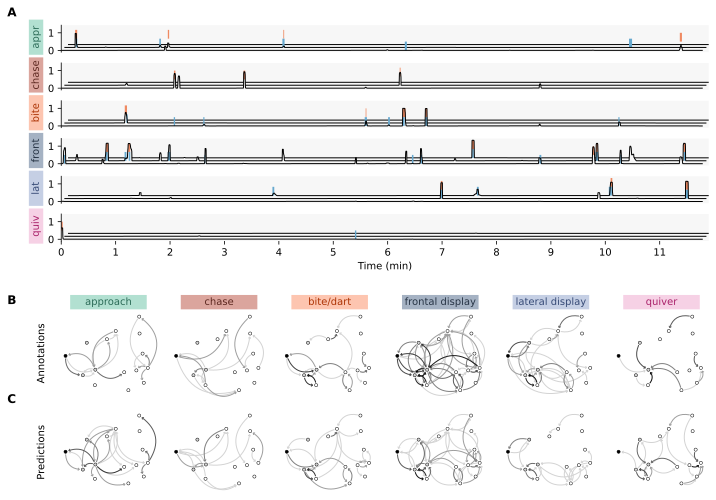

In [25]:
scores = aggregate_scores(summary, "prediction_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (9, 6.5)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))

top, middle = panel.divide(sizes_absolute=[0, 2.5], orientation="vertical", spacing_absolute=1)

panels_timeline = top.divide(sizes=[1] * len(dataset_test.foreground_categories), spacing_absolute=0.15, orientation="vertical")

row_1, row_2 = middle.divide(sizes=[1, 1], orientation="vertical", spacing=0.1)

panels_row_1 = row_1.divide(sizes=[1] * len(group_annotated.foreground_categories), spacing=0.025, orientation="horizontal")
panels_row_2 = row_2.divide(sizes=[1] * len(group_annotated.foreground_categories), spacing=0.025, orientation="horizontal")

labels = {0: "A", 1: "B", 2: "C"}

axes_timeline = [panel.get_ax(fig, label=labels.pop(0, None)) for panel in panels_timeline]
axes_annotated = [panel.get_ax(fig, label=labels.pop(1, None), spines=[False] * 4) for panel in panels_row_1]
axes_predicted = [panel.get_ax(fig, label=labels.pop(2, None), spines=[False] * 4) for panel in panels_row_2]

foreground = np.isin(dataset_test.categories, dataset_test.foreground_categories)

for idx, recipient in enumerate(recipients):

    dyad_results = test_result.classification_results["GH030861"].classification_results[(actor, recipient)]  # GH030861: 6, 9
    plot_classification_timeline(
        dyad_results.predictions,
        dataset_test.foreground_categories,
        annotations=dyad_results.annotations,
        timestamps=dyad_results.timestamps,
        y_proba_smoothed=dyad_results.y_proba_smoothed[:, foreground],
        interval=(-np.inf, np.inf),
        x_tick_step=(30 * 60),
        x_tick_conversion=lambda ticks: (np.asarray(ticks) / (30 * 60)).astype(int),
        y_offset=idx / 6,
        x_offset=idx * 120,
        zorder=-idx,
        axes=axes_timeline,
    )

for label, ax, color in zip(
    np.array(category_labels)[foreground],
    axes_timeline,
    np.array(colors)[foreground],
):
    ax.set_ylabel(None)
    vis.add_ytick_box(0.5 + 3 / (6 * 2), 2, ax, color=color, text=label, offset_in_inches=0.25, **box_kwargs)
ax.set_xlabel("Time (min)")

####

for idx, category in enumerate(group_annotated.foreground_categories):
    draw_network(
        axes_annotated[idx], interaction_matrices_annotated[category], locations, cmap, norm,
        fc=[("black" if ind == actor else ("lightgray" if ind in recipients else "white")) for ind in group_annotated.individuals],
    )
    draw_network(
        axes_predicted[idx], interaction_matrices_predicted[category], locations, cmap, norm,
        fc=[("black" if ind == actor else ("lightgray" if ind in recipients else "white")) for ind in group_annotated.individuals],
    )
    
    axes_annotated[idx].set_xticks([])
    axes_predicted[idx].set_xticks([])
    axes_annotated[idx].set_yticks([])
    axes_predicted[idx].set_yticks([])

    if idx > 0:
        axes_annotated[idx].sharex(axes_annotated[0])
        axes_predicted[idx].sharex(axes_predicted[0])
        axes_annotated[idx].sharey(axes_annotated[0])
        axes_predicted[idx].sharey(axes_predicted[0])
        
axes_annotated[0].set_ylabel("Annotations", labelpad=15)
axes_predicted[0].set_ylabel("Predictions", labelpad=15)

for ax, color, category in zip(
    axes_annotated,
    ["#66C2A5", "#B84D3D", "#FC8D62", "#4C6688", "#8DA0CB", "#EEA5CC"],
    group_annotated.foreground_categories,
):
    if category == "dart_bite":
        category = "bite/dart"
    category = category.replace("_", " ")
    vis.add_xtick_box(np.mean(ax.get_xlim()), np.diff(ax.get_xlim())[0] - 400, ax, offset_in_inches=0.05, y="top", text=category, color=color, **box_kwargs)

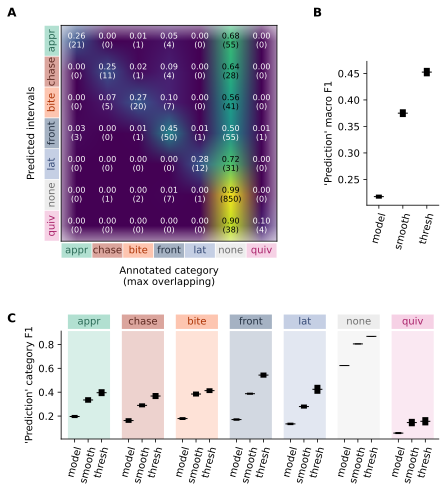

In [26]:
scores = aggregate_scores(summary, "prediction_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (5.25, 5.75)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))
top, bottom = panel.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="vertical")
panels_top = top.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="horizontal")

ax_confusion = panels_top[0].get_ax(fig, label="A", spines=[True] * 4)
right = panels_top[1].divide(sizes_absolute=[0.5, 2, 0], spacing=0, orientation="vertical")
right[0].get_ax(fig, label="B").axis("off")  # emtpy axes aligned with confusion matrix
ax_macro_f1 = right[1].get_ax(fig)  # actual axes for errorbars
ax_category_f1 = bottom.get_ax(fig, label="C")

####

plot_confusion_matrix(
    np.array([y["pred"]["prediction"] for y in confusion], dtype=object),
    np.array([y["true"]["prediction"] for y in confusion], dtype=object),
    show_colorbar=False,
    ax=ax_confusion,
)
ax_confusion.set_ylabel("Predicted intervals", labelpad=25)
ax_confusion.set_xlabel("Annotated category\n(max overlapping)", labelpad=25)

vis.add_xtick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)

####

plot_errorbars(
    ax_macro_f1,
    *scores["macro-all"].to_numpy().T,
    ylabel="'Prediction' macro F1",
)

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories / 1.75]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
plot_errorbars(
    ax_category_f1,
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Prediction' category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    ax_category_f1.axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        ax_category_f1,
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )

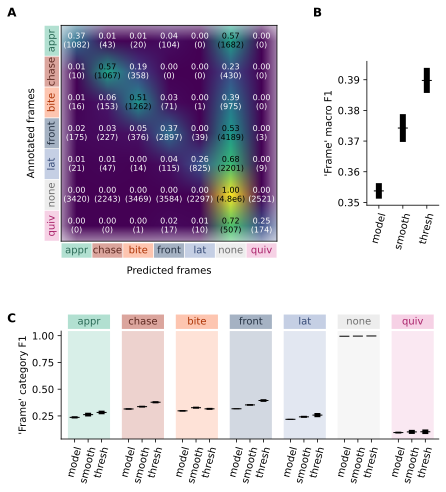

In [27]:
scores = aggregate_scores(summary, "timestamp_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (5.25, 5.75)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))
top, bottom = panel.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="vertical")
panels_top = top.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="horizontal")

ax_confusion = panels_top[0].get_ax(fig, label="A", spines=[True] * 4)
right = panels_top[1].divide(sizes_absolute=[0.5, 2, 0], spacing=0, orientation="vertical")
right[0].get_ax(fig, label="B").axis("off")  # emtpy axes aligned with confusion matrix
ax_macro_f1 = right[1].get_ax(fig)  # actual axes for errorbars
ax_category_f1 = bottom.get_ax(fig, label="C")

####

plot_confusion_matrix(
    [y["true"]["timestamp"] for y in confusion],
    [y["pred"]["timestamp"] for y in confusion],
    show_colorbar=False,
    ax=ax_confusion,
)

ax_confusion.set_xlabel("Predicted frames", labelpad=25)
ax_confusion.set_ylabel("Annotated frames", labelpad=25)

vis.add_xtick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)

####

plot_errorbars(
    ax_macro_f1,
    *scores["macro-all"].to_numpy().T,
    ylabel="'Frame' macro F1",
)

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories / 1.75]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
plot_errorbars(
    ax_category_f1,
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Frame' category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    ax_category_f1.axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        ax_category_f1,
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )

In [32]:
test_observations = dataset_test.observations
test_observations.groupby("category").aggregate({"category": "count"})

,category
category,
approach,50
chase,34
dart_bite,60
frontal_display,154
lateral_display,49
none,710
quiver,16


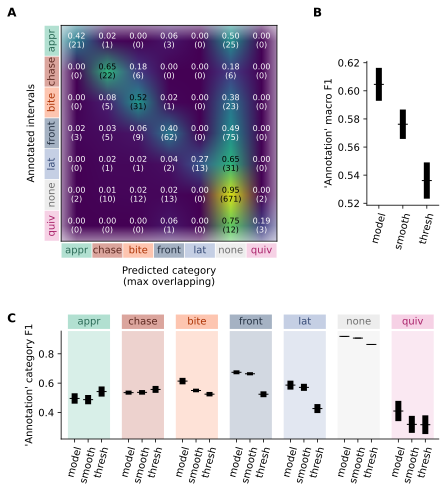

In [33]:
scores = aggregate_scores(summary, "annotation_f1", categories=dataset_test.categories)
num_steps = 3
num_categories = len(dataset_test.categories)

figsize = (5.25, 5.75)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))
top, bottom = panel.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="vertical")
panels_top = top.divide(sizes_absolute=[3, 0], spacing_absolute=1.25, orientation="horizontal")

ax_confusion = panels_top[0].get_ax(fig, label="A", spines=[True] * 4)
right = panels_top[1].divide(sizes_absolute=[0.5, 2, 0], spacing=0, orientation="vertical")
right[0].get_ax(fig, label="B").axis("off")  # emtpy axes aligned with confusion matrix
ax_macro_f1 = right[1].get_ax(fig)  # actual axes for errorbars
ax_category_f1 = bottom.get_ax(fig, label="C")

####

plot_confusion_matrix(
    [y["true"]["annotation"] for y in confusion],
    [y["pred"]["annotation"] for y in confusion],
    show_colorbar=False,
    ax=ax_confusion,
)
ax_confusion.set_xlabel("Predicted category\n(max overlapping)", labelpad=25)
ax_confusion.set_ylabel("Annotated intervals", labelpad=25)

vis.add_xtick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)
vis.add_ytick_boxes(range(len(category_labels)), 0.975, ax_confusion, labels=category_labels, colors=colors, **box_kwargs)

####

plot_errorbars(
    ax_macro_f1,
    *scores["macro-all"].to_numpy().T,
    ylabel="'Annotation' macro F1",
)

x = [x for idx in range(num_categories) for x in np.arange(num_steps) + idx * num_categories / 1.75]
means, stds = pd.concat([scores[category] for category in dataset_test.categories]).to_numpy().T
plot_errorbars(
    ax_category_f1,
    means,
    stds,
    x=x,
    padding=1,
    xticklabels=("model", "smooth", "thresh") * num_categories,
    ylabel="'Annotation' category F1",
)
for (idx, category), color in zip(enumerate(category_labels), colors):
    x_left = x[num_steps * idx] - 0.5
    x_right = x[num_steps * (idx + 1) - 1] + 0.625
    ax_category_f1.axvspan(x_left, x_right, color=color, alpha=0.25, lw=0)
    vis.add_xtick_box(
        (x_left + x_right) / 2,
        x_right - x_left,
        ax_category_f1,
        y="top",
        text=category,
        color=color,
        **box_kwargs,
    )

In [20]:
from matplotlib.colors import ListedColormap

In [21]:
import automated_scoring.visualization as vis

In [ ]:
# dataset_predictions = test_result.to_dataset(
#     trajectories={identifier: group.trajectories for identifier, group in dataset_test},
#     background_category=dataset_test.background_category,
# )

In [ ]:
# from automated_scoring.io import save_dataset

# save_dataset(dataset_predictions, dataset_name="test_predictions", directory="../../datasets/social_cichlids/", observation_suffix="predictions")

In [ ]:
annotations = dataset_test.observations
predictions = test_result.predictions

In [ ]:
dyads = [(group_identifier, *identifier) for group_identifier, group in dataset_test for identifier in group.identifiers]

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from automated_scoring import features

In [729]:
average_body_length = np.mean(
    [
        features.keypoint_distances(trajectory, keypoints_1=(0, 1), keypoints_2=(1, 2), element_wise=True).sum(axis=1).mean()
        for _, group in dataset_test
        for trajectory in group.trajectories.values()
    ]
)

subsets = {
    category: [category]
    for category in dataset_test.foreground_categories
}

for distance_factor in [1, 5, 3]:

    aggregated_counts = []
    
    for idx, (subset, categories_subset) in enumerate(subsets.items()):
    
        identifier_columns = ["group", "actor", "recipient"]
        
        annotated_counts = pd.DataFrame(dyads, columns=identifier_columns)
        annotated_counts["count"] = 0
        annotated_counts["duration"] = 0
        annotated_counts["duration_associated"] = 0
        annotated_counts = annotated_counts.set_index(identifier_columns)
        grouped = annotations.groupby(identifier_columns)
        for dyad in dyads:
            dyad_data = dataset_test.select(dyad[0]).select(dyad[1:])
            distances = features.keypoint_distances(
                dyad_data.trajectory,
                trajectory_other=dyad_data.trajectory_other,
                keypoints_1=(0, 1, 2),
                keypoints_2=(0, 1, 2),
                flat=True,
            )
            dyad_observations = grouped.get_group(dyad)
            annotated_counts.loc[dyad, "count"] = np.isin(dyad_observations["category"], categories_subset).sum()
            annotated_counts.loc[dyad, "duration"] = len(dataset_test.select(dyad[0]).select(dyad[1:]))
            annotated_counts.loc[dyad, "duration_associated"] = np.sum(distances.min(axis=1) < distance_factor * average_body_length)
        annotated_counts = annotated_counts.reset_index()
        
        predicted_counts = pd.DataFrame(dyads, columns=identifier_columns)
        predicted_counts["count"] = 0
        predicted_counts = predicted_counts.set_index(identifier_columns)
        grouped = predictions.groupby(identifier_columns)
        for dyad in dyads:
            dyad_observations = grouped.get_group(dyad)
            predicted_counts.loc[dyad, "count"] = np.isin(dyad_observations["category"], categories_subset).sum()
            predicted_counts
        predicted_counts = predicted_counts.reset_index()
        
        counts = pd.DataFrame(
            {
                "body_length": distance_factor,
                "count_annotated": annotated_counts["count"],
                "count_predicted": predicted_counts["count"],
                "duration": annotated_counts["duration"],
                "duration_associated": annotated_counts["duration_associated"],
            },
        )
        counts[identifier_columns] = dyads
        counts["categories_subset"] = subset
    
        aggregated_counts.append(counts)
    
    aggregated_counts = pd.concat(aggregated_counts)

    aggregated_counts.to_csv(f"/home/paul/automated_scoring-testing/figures/aggregated_counts-{distance_factor}bl.csv", index=False)

In [731]:
aggregated_counts

,body_length,count_annotated,count_predicted,duration,duration_associated,group,actor,recipient,categories_subset
0,3,0,1,9076,547,GH010423,0,1,approach
1,3,0,0,9076,64,GH010423,0,2,approach
2,3,0,0,9076,210,GH010423,0,3,approach
3,3,0,1,9076,636,GH010423,0,4,approach
4,3,0,1,6103,371,GH010423,0,5,approach
...,...,...,...,...,...,...,...,...,...
370,3,0,0,21210,2721,GH039931,10,11,quiver
371,3,0,1,20396,302,GH039931,10,12,quiver
372,3,0,0,20527,0,GH039931,10,13,quiver
373,3,0,0,21210,0,GH039931,10,14,quiver


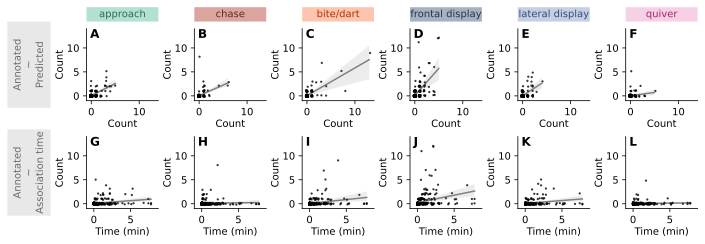

In [734]:
import seaborn as sns

figsize = (9, 2.6)
fig = plt.figure(figsize=figsize)

panel = vis.Panel(*figsize, extent=(0, 0, *figsize))

top, bottom = panel.divide(sizes_absolute=[1, 1], spacing_absolute=0.5, orientation="vertical")

panels_count = top.divide(sizes_absolute=[1] * 6, spacing_absolute=0.5, orientation="horizontal")
panel_association = bottom.divide(sizes_absolute=[1] * 6, spacing_absolute=0.5, orientation="horizontal")

labels_count = ["A", "B", "C", "D", "E", "F"]
labels_association = ["G", "H", "I", "J", "K", "L"]
axes_count = [panel.get_ax(fig, label=labels_count.pop(0), label_offset=(0.05, 0)) for panel in panels_count]
axes_association = [panel.get_ax(fig, label=labels_association.pop(0), label_offset=(0.05, 0)) for panel in panel_association]

aggregated_counts["duration_associated_min"] = aggregated_counts["duration_associated"] / (30 * 60)

max_association = aggregated_counts["duration_associated_min"].max()
max_count = np.asarray(aggregated_counts[["count_predicted", "count_annotated"]]).max()

for idx, subset in enumerate(subsets):

    interaction_counts = aggregated_counts.loc[aggregated_counts["categories_subset"] == subset]
    n_dyads = len(interaction_counts)
    
    sns.regplot(
        data=interaction_counts,
        x="count_predicted",
        y="count_annotated",
        ax=axes_count[idx],
        x_jitter=0.2,
        y_jitter=0.2,
        scatter_kws=dict(s=5, color="k", linewidths=0),
        line_kws=dict(lw=1.5, color="gray", zorder=-1),
    )
    
    sns.regplot(
        data=interaction_counts,
        x="duration_associated_min",
        y="count_annotated",
        ax=axes_association[idx],
        y_jitter=0.2,
        scatter_kws=dict(s=5, color="k", linewidths=0),
        line_kws=dict(lw=1.5, color="gray", zorder=-1),
    )
    axes_count[idx].set_xlim(-1, max_count + 1)
    axes_count[idx].set_ylim(-1, max_count + 1)
    axes_association[idx].set_xlim(-1, max_association + 1)
    axes_association[idx].set_ylim(-1, max_count + 1)

    axes_count[idx].set_ylabel("Count", labelpad=2)
    axes_count[idx].set_xlabel("Count", labelpad=2)
    axes_association[idx].set_ylabel("Count", labelpad=2)
    axes_association[idx].set_xlabel("Time (min)", labelpad=2)
    


def get_xtick_box(ax, factor=1):
    return np.mean(ax.get_xlim()), np.diff(ax.get_xlim())[0] * factor, ax

def get_ytick_box(ax, factor=1):
    return np.mean(ax.get_ylim()), np.diff(ax.get_ylim())[0] * factor, ax

for ax, subset, color in zip(axes_count, subsets, np.array(colors)[foreground]):
    category = subset
    if category == "dart_bite":
        category = "bite/dart"
    category = category.replace("_", " ")
    vis.add_xtick_box(*get_xtick_box(ax), y="top", text=category, color=color, offset_in_inches=0.1, **box_kwargs)

vis.add_ytick_box(
    *get_ytick_box(axes_count[0], 1.2), text="Annotated\n~\nPredicted",
    width_in_inches=0.6, offset_in_inches=0.5, color="lightgrey", **box_kwargs,
)
vis.add_ytick_box(
    *get_ytick_box(axes_association[0], 1.2), text="Annotated\n~\nAssociation time",
    width_in_inches=0.6, offset_in_inches=0.5, color="lightgrey", **box_kwargs,
)

plt.show()

In [721]:
scores = []
formatted = {}

for f1 in ["timestamp", "annotation", "prediction"]:
    aggregated = aggregate_scores(summary, f"{f1}_f1", categories=dataset_test.categories).reset_index()
    aggregated["f1"] = f1
    scores.append(aggregated.set_index("f1"))

scores = pd.concat(scores).reset_index()
formatted["F1"] = scores["f1"]
formatted["Postprocessing step"] = scores["postprocessing_step"]

for column in scores.columns.droplevel(1)[2:]:
    column_formatted = column.replace("-", " (")
    if "(" in column_formatted:
        column_formatted += ")"
    column_formatted = column_formatted.replace("_", " ")
    formatted[column_formatted.capitalize()] = scores[column].apply(lambda values: f"{values["mean"]:.03f}±{values["std"]:.03f}", axis=1)

formatted = pd.DataFrame(formatted)
formatted.map(lambda s: s.replace("_", " ").capitalize())

,F1,Postprocessing step,Macro (foreground),Macro (all),Approach,Chase,Dart bite,Frontal display,Lateral display,None,Quiver
0,Timestamp,Model outputs,0.247±0.003,0.354±0.003,0.237±0.010,0.315±0.007,0.298±0.007,0.317±0.004,0.219±0.004,0.995±0.000,0.095±0.008
1,Timestamp,Smoothed,0.271±0.005,0.374±0.005,0.262±0.017,0.337±0.008,0.327±0.010,0.353±0.008,0.242±0.009,0.996±0.000,0.101±0.019
2,Timestamp,Thresholded,0.289±0.005,0.390±0.004,0.283±0.017,0.378±0.010,0.316±0.009,0.394±0.012,0.258±0.020,0.997±0.000,0.102±0.021
3,Annotation,Model outputs,0.552±0.013,0.605±0.012,0.495±0.035,0.535±0.014,0.614±0.022,0.674±0.014,0.586±0.031,0.919±0.003,0.409±0.069
4,Annotation,Smoothed,0.521±0.012,0.576±0.010,0.487±0.032,0.537±0.016,0.550±0.012,0.664±0.011,0.571±0.024,0.907±0.003,0.318±0.058
5,Annotation,Thresholded,0.482±0.015,0.536±0.013,0.542±0.035,0.557±0.024,0.524±0.015,0.524±0.020,0.426±0.031,0.864±0.003,0.316±0.064
6,Prediction,Model outputs,0.150±0.005,0.217±0.004,0.196±0.013,0.162±0.020,0.179±0.012,0.171±0.010,0.134±0.010,0.623±0.002,0.057±0.008
7,Prediction,Smoothed,0.303±0.008,0.375±0.007,0.335±0.023,0.290±0.017,0.385±0.021,0.387±0.009,0.279±0.017,0.805±0.004,0.145±0.031
8,Prediction,Thresholded,0.383±0.009,0.453±0.008,0.396±0.029,0.368±0.025,0.413±0.020,0.543±0.021,0.424±0.038,0.868±0.003,0.156±0.035


In [723]:
formatted.to_csv("/home/paul/automated_scoring-testing/figures/scores.csv", index=False)